# Notebook pro trénink s destilací nad datasetem CIFAR10
V tomto notebooku je trénován MobileNetV2 nad datasetem CIFAR10, jako učitelsý model je využíván finetunued ViT nad stejným datasetem. 

MobileNetV2 je používán s náhodnou inicializací, tréninkem pouze klasifikační hlavy inicializovaného (předtrénovaného nad ImageNetem) MobileNetuV2 a trénink celého modelu, taktéž inicializovaného. Tyto tři úlohy jsou trénovány bězným způsobem a také s pomocí destilace výše zmíněného modelu.  

Při destilaci je využíváno předpočítaných logitů ze sešitu precompute_logits.

In [1]:
%pip install transformers[torch] huggingface_hub datasets evaluate torchvision

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import knihoven a definice metod

In [2]:
from transformers import Trainer, TrainingArguments, MobileNetV2Config, MobileNetV2ForImageClassification, EarlyStoppingCallback
from torchvision.transforms import v2 as transformsv2
from torch.utils.data import Dataset
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
from enum import Enum
import numpy as np
import evaluate
import random
import pickle
import torch
import os

In [3]:
dataset_part = Enum('dataset_part', [('TRAIN', 1), ('TEST', 2), ('EVAL', 3)])

Resetování náhodného seedu pro replikovatelnost výsledků.
Zřejmě je možné části odebrat.

TODO: Odebrat zbytečná nastavení.

In [4]:
def reset_seed(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

Nový wrapper, který pracuje přímo se soubory staženého a upraveného datasetu CIFAR10.
Využití načtení pomocí metody jako dříve není možné kvůli jiné checksum. 

Zároveň se již dotahují logity přímo z datasetu.

In [5]:
reset_seed(42)

In [162]:
class CustomCIFAR10(Dataset):
    def __init__(self, root, dataset_part = dataset_part.TRAIN, transform=None):
        self.root = root
        self.dataset_part = dataset_part
        self.transform = transform
        self.data = []
        self.targets = []
        self.logits = []
        self.logits_aug = []

        if self.dataset_part == dataset_part.TRAIN:
             for i in range(1, 5):
                 data_file = os.path.join(self.root, 'cifar-10-batches-py', f'train_batch_{i}')
                 with open(data_file, 'rb') as fo:
                     dict = pickle.load(fo, encoding='bytes')
                     self.data.append(dict[b'data'])
                     self.targets.extend(dict[b'labels'])
                     self.logits.extend(dict[b'logits'])
                     self.logits_aug.extend(dict[b'logits_aug'])   

        elif self.dataset_part == dataset_part.TEST:
            data_file = os.path.join(self.root, 'cifar-10-batches-py', 'test')
            with open(data_file, 'rb') as fo:
                dict = pickle.load(fo, encoding='bytes')
                self.data.append(dict[b'data'])
                self.targets.extend(dict[b'labels'])
                self.logits.extend(dict[b'logits'])
        else:
            data_file = os.path.join(self.root, 'cifar-10-batches-py', 'eval')
            with open(data_file, "rb") as fo:
                dict = pickle.load(fo, encoding='bytes')
                self.data.append(dict[b'data'])
                self.targets.extend(dict[b'labels'])
                self.logits.extend(dict[b'logits'])
                
        self.data = np.concatenate(self.data, axis=0)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        label = self.targets[index]
        #logit = self.logits[index]

        if self.transform:
            logit = self.logits[index] if len(self.transform.extra_repr()) < 300 else self.logits_aug[index]
            logit = torch.tensor(logit, dtype=torch.float)
            torch.manual_seed(index%10000)
            image = self.transform(image)

        
        
            

        return {
            'pixel_values': image,
            'labels': label,
            'logits': logit,
        }
    
    def remove_entries(self, remove_list):
        self.data = np.delete(self.data, remove_list, axis=0)
        self.targets = np.delete(self.targets, remove_list, axis=0)
        self.logits = np.delete(self.logits, remove_list, axis=0)
        self.logits_aug = np.delete(self.logits_aug, remove_list, axis=0)
    
    @property
    def labels(self):
        return self.targets


Definice accuracy metriky pro trénování modelu.

In [97]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    pred, labels = eval_pred
    predictions = np.argmax(pred, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='macro', zero_division = 0)
    recall = recall_metric.compute(predictions=predictions, references=labels, average='macro', zero_division = 0)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

Trénovací argumenty pro trainer. 

In [98]:
class Custom_training_args(TrainingArguments):
    def __init__(self, lambda_param, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)    
        self.lambda_param = lambda_param
        self.temperature = temperature

In [99]:
def get_training_args(output_dir, logging_dir, remove_unused_columns=True, lr=5e-5, epochs=5, weight_decay=0, lambda_param=.5, temp=5):
    return (
        Custom_training_args(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=lr, #Defaultní hodnota 
        per_device_train_batch_size=128,
        per_device_eval_batch_size=128,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        seed = 42,  #Defaultní hodnota 
        metric_for_best_model="f1",
        load_best_model_at_end = True,
        fp16=True, 
        logging_dir=logging_dir,
        remove_unused_columns=remove_unused_columns,
        lambda_param = lambda_param, 
        temperature = temp
    ))

Náhodně inicializovaný MobileNetV2.

In [100]:
def get_random_init_mobilenet():
    reset_seed(42)
    student_config = MobileNetV2Config()
    student_config.num_labels = 10
    return MobileNetV2ForImageClassification(student_config)

Zamražení modelu a trénink pouze klasifikační hlavy.

In [101]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True

Inicializovaný MobileNetV2.

In [102]:
def get_mobilenet():
    model_pretrained = MobileNetV2ForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")
    in_features = model_pretrained.classifier.in_features

    model_pretrained.classifier = nn.Linear(in_features,10) #Úprava klasifikační hlavy
    model_pretrained.num_labels = 10
    model_pretrained.config.num_labels = 10

    return model_pretrained

In [103]:
reset_seed(42)

In [104]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and will be used:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

GPU is available and will be used: NVIDIA A100 80GB PCIe MIG 2g.20gb


Provedení transformací nad datasetem.

In [163]:
transform = transformsv2.Compose([
    transformsv2.ToImage(),
    transformsv2.ToDtype(torch.float32, scale=True),
    transformsv2.Resize((224, 224), antialias=True),
    transformsv2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#Poslední train batch použijeme jako eval část...
test = CustomCIFAR10(root='./data/10-logits', dataset_part=dataset_part.TEST, transform=transform)
train = CustomCIFAR10(root='./data/10-logits', dataset_part=dataset_part.TRAIN, transform=transform)
eval = CustomCIFAR10(root='./data/10-logits', dataset_part=dataset_part.EVAL, transform=transform)

In [106]:
print(len(transform.extra_repr()))

207


In [107]:
augment_transform = transformsv2.Compose([ 
    transformsv2.ToImage(),
    transformsv2.ToDtype(torch.float32, scale=True),
    transformsv2.Resize(size=(224, 224), antialias=True),
    transformsv2.RandomHorizontalFlip(),
    transformsv2.RandomVerticalFlip(),
    transformsv2.RandomRotation(15),
    transformsv2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_aug = CustomCIFAR10(root='./data/10-logits', dataset_part=dataset_part.TRAIN, transform=augment_transform)


In [108]:
rem_ls = []

for index, val in enumerate(train_aug):
    target_alt = torch.topk(val["logits"], k=1).indices.numpy()[0]
    target_act = torch.topk(train[index]["logits"], k=1).indices.numpy()[0]
    if target_alt != target_act:
        rem_ls.append(index)
train_aug.remove_entries(rem_ls)

In [109]:
train_combo = torch.utils.data.ConcatDataset([train, train_aug])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4657085].


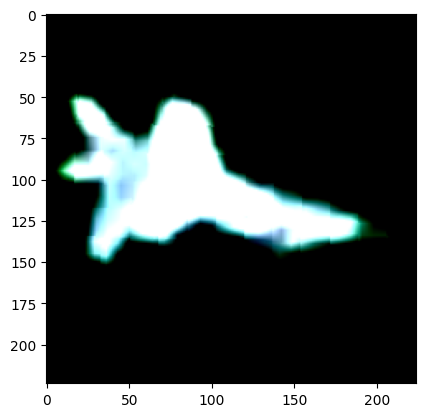

In [110]:
import matplotlib.pyplot as plt
plt.imshow(train_aug[50]["pixel_values"].permute(1, 2, 0))


In [111]:
# Test rozložení --> Good Enough
import pandas as pd
df = pd.DataFrame(eval.labels)
print(df.value_counts())

0
5    1025
9    1022
3    1016
0    1014
1    1014
8    1003
4     997
6     980
7     977
2     952
Name: count, dtype: int64


### Standardní trénink náhodně inicializovaného modelu. 

In [112]:
reset_seed(42)

In [113]:
training_args = get_training_args(output_dir="./results/cifar10-random", logging_dir='./logs/cifar10-random', lr=0.0005,  epochs=30)
model = get_random_init_mobilenet()
model.to(device)

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [114]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_combo,
    eval_dataset=eval,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 4)]
)

In [115]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.463800,1.037930,0.641100,0.641416,0.640152,0.634947
2,0.960100,0.749105,0.738300,0.741586,0.737722,0.737781
3,0.759100,0.639601,0.779100,0.778725,0.779504,0.776135
4,0.627700,0.555916,0.806900,0.808455,0.806523,0.804390
5,0.531900,0.502715,0.829000,0.828873,0.828787,0.827541
6,0.451000,0.486683,0.831300,0.831596,0.831682,0.829763
7,0.389500,0.470692,0.840200,0.846481,0.840874,0.840412
8,0.325900,0.435173,0.852600,0.856123,0.852471,0.853282
9,0.269000,0.453755,0.855700,0.862448,0.855463,0.857196
10,0.219700,0.490151,0.851100,0.854547,0.851239,0.851187


TrainOutput(global_step=15990, training_loss=0.23267211390331882, metrics={'train_runtime': 9218.0307, 'train_samples_per_second': 221.878, 'train_steps_per_second': 1.735, 'total_flos': 4.1316693274283213e+18, 'train_loss': 0.23267211390331882, 'epoch': 30.0})

In [116]:
model.eval()

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [117]:
trainer.evaluate(test)

{'eval_loss': 0.793152928352356,
 'eval_accuracy': 0.871,
 'eval_precision': 0.8718504007131591,
 'eval_recall': 0.8709999999999999,
 'eval_f1': 0.8707612282318162,
 'eval_runtime': 16.546,
 'eval_samples_per_second': 604.376,
 'eval_steps_per_second': 4.775,
 'epoch': 30.0}

## Definice destilačního tréninku

Třída, která upravuje hugging face trenéra pro destilaci znalostí. Nově pracuje s logity uloženými v datasetu.

In [146]:
class ImageDistilTrainer(Trainer):
    def __init__(self, student_model=None, *args, **kwargs):
        super().__init__(model=student_model, *args, **kwargs)
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        self.temperature = self.args.temperature
        self.lambda_param = self.args.lambda_param



    def compute_loss(self, student, inputs, return_outputs=False, num_items_in_batch=None):
        logits = inputs.pop("logits")

        student_output = student(**inputs)

        soft_teacher = F.softmax(logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)


        distillation_loss = self.loss_function(soft_student, soft_teacher) * (self.temperature ** 2)


        student_target_loss = student_output.loss

        loss = ((1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss)
        return (loss, student_output) if return_outputs else loss

### Trénink náhodně inicializovaného modelu s pomocí destilace znalostí

In [147]:
reset_seed(42)

In [148]:
student_model = get_random_init_mobilenet()

In [149]:
training_args = get_training_args(output_dir="./results/cifar10-random-KD", logging_dir='./logs/cifar10-random-KD', remove_unused_columns=False, epochs=30, lr=0.00047, lambda_param=.75, temp=6)

In [150]:
trainer = ImageDistilTrainer(
    student_model=student_model,
    args=training_args,
    train_dataset=train_combo,
    eval_dataset=eval,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 4)]
)

In [151]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.738300,0.545457,0.648800,0.653876,0.648107,0.644203
2,0.496600,0.396176,0.754000,0.767343,0.753355,0.755172
3,0.403600,0.344784,0.789800,0.796058,0.790547,0.785987
4,0.349500,0.320562,0.805300,0.806584,0.805155,0.802286
5,0.310800,0.286864,0.835900,0.838791,0.836096,0.835011
6,0.281000,0.276472,0.837600,0.842309,0.837690,0.838338
7,0.256700,0.255284,0.850400,0.858105,0.851103,0.850481
8,0.235700,0.239922,0.862200,0.865662,0.862366,0.862374
9,0.216400,0.244177,0.864500,0.873414,0.864458,0.866097
10,0.200900,0.248147,0.860100,0.863130,0.860333,0.859171


TrainOutput(global_step=10127, training_loss=0.25784423879354273, metrics={'train_runtime': 6568.3481, 'train_samples_per_second': 311.384, 'train_steps_per_second': 2.434, 'total_flos': 2.61672390737127e+18, 'train_loss': 0.25784423879354273, 'epoch': 19.0})

In [152]:
student_model.eval()

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [164]:
trainer.evaluate(test)

{'eval_loss': 0.23366013169288635,
 'eval_accuracy': 0.8686,
 'eval_precision': 0.8718026172399451,
 'eval_recall': 0.8686,
 'eval_f1': 0.869042110700704,
 'eval_runtime': 17.3081,
 'eval_samples_per_second': 577.766,
 'eval_steps_per_second': 4.564,
 'epoch': 19.0}

## Získání inicializovaného MobileNetV2 modelu

In [29]:
reset_seed(42)

In [30]:
model_pretrained = get_mobilenet()

In [31]:
print(model_pretrained)

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [32]:
freeze_model(model_pretrained)

In [33]:
training_args = get_training_args(output_dir="./results/cifar10-pretrained-head", logging_dir='./logs/cifar10-pretrained-head')

In [34]:
trainer = Trainer(
    model=model_pretrained,
    args=training_args,
    train_dataset=train,
    eval_dataset=eval,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 2)]
)

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.983500,1.666508,0.583500,0.586924,0.582902,0.578297
2,1.515100,1.370681,0.655000,0.658174,0.654084,0.651459
3,1.303700,1.236479,0.675500,0.671237,0.674684,0.669260
4,1.207600,1.175666,0.689500,0.690785,0.689174,0.687818
5,1.167200,1.183259,0.682600,0.688172,0.682072,0.683982


TrainOutput(global_step=1565, training_loss=1.435398460120058, metrics={'train_runtime': 676.8433, 'train_samples_per_second': 295.489, 'train_steps_per_second': 2.312, 'total_flos': 4.040199217152e+17, 'train_loss': 1.435398460120058, 'epoch': 5.0})

In [36]:
model_pretrained.eval()

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [37]:
trainer.evaluate(test)

{'eval_loss': 1.1798793077468872,
 'eval_accuracy': 0.6864,
 'eval_precision': 0.6879813785360978,
 'eval_recall': 0.6864,
 'eval_f1': 0.6848686230961495,
 'eval_runtime': 24.3581,
 'eval_samples_per_second': 410.541,
 'eval_steps_per_second': 3.243,
 'epoch': 5.0}

### Trénink inicializovaného MobileNetV2

In [38]:
reset_seed(42)

In [39]:
model_pretrained_whole = get_mobilenet()

In [40]:
training_args = get_training_args(output_dir="./results/cifar10-pretrained", logging_dir='./logs/cifar10-pretrained')

In [41]:
trainer = Trainer(
    model=model_pretrained_whole,
    args=training_args,
    train_dataset=train,
    eval_dataset=eval,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)]
)

In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.717100,0.357813,0.878000,0.883757,0.877975,0.878126
2,0.241900,0.285486,0.904800,0.909034,0.904613,0.905530
3,0.148800,0.261888,0.909000,0.910553,0.908979,0.909042
4,0.100200,0.245204,0.916700,0.918190,0.916911,0.916785
5,0.073600,0.254316,0.916400,0.917647,0.916710,0.916418


TrainOutput(global_step=1565, training_loss=0.25632537134920064, metrics={'train_runtime': 768.3689, 'train_samples_per_second': 260.292, 'train_steps_per_second': 2.037, 'total_flos': 4.040199217152e+17, 'train_loss': 0.25632537134920064, 'epoch': 5.0})

In [43]:
model_pretrained_whole.eval()

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [44]:
trainer.evaluate(test)

{'eval_loss': 0.2556077837944031,
 'eval_accuracy': 0.9174,
 'eval_precision': 0.9186320015704013,
 'eval_recall': 0.9174000000000001,
 'eval_f1': 0.917269695640841,
 'eval_runtime': 24.0426,
 'eval_samples_per_second': 415.929,
 'eval_steps_per_second': 3.286,
 'epoch': 5.0}

## Trénink s pomocí destilace znalostí inicializovaného MobileNetV2

### Trénink inicializovaného modelu - pouze klasifikační hlavy s pomocí destilace

In [45]:
reset_seed(42)

In [46]:
student_model_pretrained = get_mobilenet()

In [47]:
freeze_model(student_model_pretrained)

In [48]:
training_args = get_training_args(output_dir="./results/cifar10-pretrained-head-KD", logging_dir='./logs/cifar10-pretrained-head-KD', remove_unused_columns=False, temp=6, lambda_param=.8)

In [49]:
trainer = ImageDistilTrainer(
    student_model=student_model_pretrained,
    args=training_args,
    train_dataset=train,
    eval_dataset=eval,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 2)]
)

In [50]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.979800,0.806478,0.585600,0.589648,0.585169,0.580398
2,0.747700,0.682494,0.660200,0.662438,0.659330,0.655939
3,0.668200,0.639946,0.679300,0.675224,0.678690,0.672222
4,0.637600,0.616990,0.692400,0.692186,0.692019,0.689034
5,0.625500,0.624481,0.689600,0.692095,0.689086,0.689528


TrainOutput(global_step=1565, training_loss=0.731778314852486, metrics={'train_runtime': 611.4863, 'train_samples_per_second': 327.072, 'train_steps_per_second': 2.559, 'total_flos': 4.040199217152e+17, 'train_loss': 0.731778314852486, 'epoch': 5.0})

In [51]:
student_model_pretrained.eval()

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [52]:
trainer.evaluate(test)

{'eval_loss': 1.215173602104187,
 'eval_accuracy': 0.688,
 'eval_precision': 0.691842072272977,
 'eval_recall': 0.688,
 'eval_f1': 0.6884649153396096,
 'eval_runtime': 22.6288,
 'eval_samples_per_second': 441.915,
 'eval_steps_per_second': 3.491,
 'epoch': 5.0}

### Trénink inicializovaného modelu s pomocí destilace

In [53]:
reset_seed(42)

In [54]:
student_model_pretrained_whole = get_mobilenet()

In [55]:
training_args = get_training_args(output_dir="./results/cifar10-pretrained-KD", logging_dir='./logs/cifar10-pretrained-KD', remove_unused_columns=False, temp=6, lambda_param=1)

In [56]:
trainer = ImageDistilTrainer(
    student_model=student_model_pretrained_whole.to(device),
    args=training_args,
    train_dataset=train,
    eval_dataset=eval,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)]
)

In [57]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.295100,0.155328,0.878000,0.885381,0.877831,0.877973
2,0.115900,0.112287,0.904300,0.908469,0.904112,0.905005
3,0.081300,0.101031,0.909300,0.910739,0.909396,0.909276
4,0.065500,0.087329,0.917600,0.920174,0.917791,0.917662
5,0.057100,0.087939,0.920200,0.921565,0.920564,0.920300


TrainOutput(global_step=1565, training_loss=0.1229662374185678, metrics={'train_runtime': 739.084, 'train_samples_per_second': 270.605, 'train_steps_per_second': 2.117, 'total_flos': 4.040199217152e+17, 'train_loss': 0.1229662374185678, 'epoch': 5.0})

In [58]:
student_model_pretrained.eval()

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [59]:
trainer.evaluate(test)

{'eval_loss': 1.5552592277526855,
 'eval_accuracy': 0.9149,
 'eval_precision': 0.9162574545858053,
 'eval_recall': 0.9148999999999999,
 'eval_f1': 0.914701817700383,
 'eval_runtime': 27.3443,
 'eval_samples_per_second': 365.707,
 'eval_steps_per_second': 2.889,
 'epoch': 5.0}